# 2: Trading Signals with LightGBM

Create trading signals and adjust parameters for the ML model

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr


import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [38]:
sns.set_style('whitegrid')

In [39]:
YEAR = 252
idx = pd.IndexSlice

In [43]:
START = '2012-01-01'
END = '2019-12-31'

## Get Data

We select the train and validation sets, and identify labels and features:

In [44]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, START:END], :]) # train & validation period
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1896265 entries, ('AAON', Timestamp('2012-01-02 00:00:00')) to ('ZWS', Timestamp('2019-12-31 00:00:00'))
Data columns (total 35 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1896265 non-null  float64
 1   dollar_vol_rank  1896265 non-null  float64
 2   rsi              1893783 non-null  float64
 3   bb_high          1892898 non-null  float64
 4   bb_low           1892891 non-null  float64
 5   SAR              1896084 non-null  float64
 6   NATR             1893783 non-null  float64
 7   ATR              1893783 non-null  float64
 8   PPO              1891836 non-null  float64
 9   MACD             1890420 non-null  float64
 10  sector           1896265 non-null  int32  
 11  r01              1896084 non-null  float64
 12  r05              1895376 non-null  float64
 13  r10              1894491 non-null  float64
 14  r21              1892544 non-null  floa

In [46]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # features are columns not containing '_fwd'

## Model Selection: Lookback, lookahead and roll-forward periods

In [47]:
tickers = data.index.get_level_values('symbol').unique()

We may want to predict 1, 5 or 21-day returns:

In [48]:
lookaheads = [1, 5, 21]

In [49]:
categoricals = ['year', 'month', 'sector', 'weekday']

We select 4.5 and one years as the length of our training periods; test periods are one and three months long. Since we are using two years (2015/16) for validation, a one-month test period implies 24 folds.

In [50]:
train_lengths = [int(4.5 * 253), 253]
test_lengths = [253, 21]

In [51]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [52]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

We always want to know how much our (gradient boosting) is improving over a simpler baseline (if at all..).

In [53]:
lr = LinearRegression()

In [54]:
lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       train_length, 
                       test_length,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 12/12 [03:24<00:00, 17.07s/it]


### Information Coefficient - Distribution by Lookahead

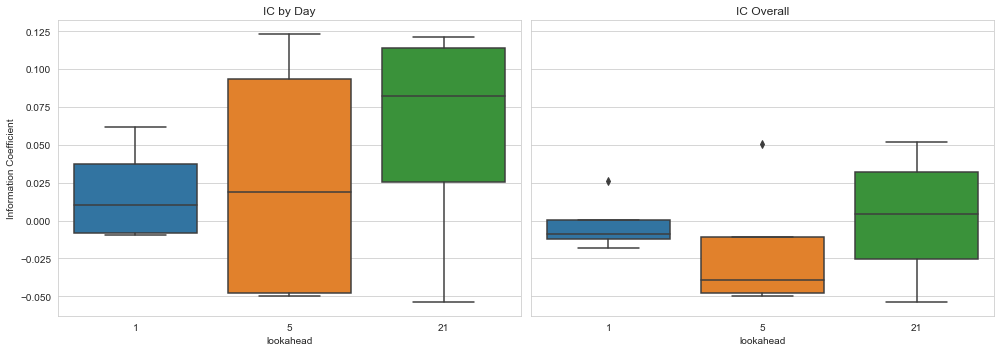

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

For one- and five-day return forecasts, shorter train- and test-length yield better results in terms of daily avg IC:

In [56]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,train_length,test_length,ic_by_day,ic
3,1,253,21,0.061836,0.025962
1,1,1138,21,0.029028,-0.017967
0,1,1138,253,-0.008058,-0.008058
7,5,253,21,0.123319,0.050678
5,5,1138,21,0.083903,-0.031678
4,5,1138,253,-0.046700,-0.046700
11,21,253,21,0.121101,0.025275
9,21,1138,21,0.111931,-0.016153
8,21,1138,253,0.052140,0.052140


In [57]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM Model Tuning

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [58]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The `base_params` are not affected by cross-validation:

In [59]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

Use the following parameters and values to select our best model:

In [60]:
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]

In [61]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [62]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [63]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

We only use test periods of 63 days length to save some model training and evaluation time.

In [64]:
train_lengths = [int(4.5 * 253), 253]
test_lengths = [63]

In [65]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

We integer-encode categorical variables with values starting at zero, as expected by LightGBM (not necessary
as long as the category codes have values less than $2^{32}$, but avoids a warning)

In [66]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [67]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

To explore the hyperparameter space, we specify values for key parameters that we would like to test in combination. The sklearn library supports `RandomizedSearchCV` to cross-validate a subset of parameter combinations that are sampled randomly from specified distributions. We will implement a custom version that allows us to monitor performance so we can abort the search process once we're satisfied with the result, rather than specifying a set number of iterations beforehand.

In [68]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [69]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [70]:
label_dict = dict(zip(lookaheads, labels))

In [71]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [72]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

We iterate over our six cross validation configurations and collect the resulting metrics (testing in order to see which hyperparameters for our ML algorithim work best):

In [73]:
# Takes around 6 hours to run the code:

for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validation
    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination, and store the results for the model
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 253 | Test: 63 | Params:  54 | Train configs: 6
	  0 | 00:00:45 ( 45) |  0.10 |  32 | 95% |  500 |  -4.27% |  0.94% |  250 |  0.77% |  500
	  1 | 00:01:15 ( 30) |  0.01 |   4 | 60% |  250 |  -3.28% |  0.78% |  500 |  1.70% |  500
	  2 | 00:02:01 ( 46) |  0.10 |  32 | 60% |  500 |  -3.74% |  0.95% |   10 |  1.06% |   25
	  3 | 00:02:30 ( 29) |  0.30 |   4 | 60% |  500 |  -2.70% |  0.91% |   50 |  1.50% |   25
	  4 | 00:02:59 ( 29) |  0.10 |   4 | 60% |  250 |  -2.91% |  1.06% |   75 |  1.36% |   75
	  5 | 00:03:50 ( 51) |  0.01 |  32 | 60% |  500 |  -4.03% |  0.99% |   10 |  0.85% |   10
	  6 | 00:05:38 (108) |  0.10 | 128 | 60% | 1000 |  -3.33% |  1.14% |   10 |  0.95% |  200
	  7 | 00:06:58 ( 80) |  0.10 | 128 | 30% | 1000 |  -3.24% |  1.14% |   75 |  1.37% |  500
	  8 | 00:08:15 ( 77) |  0.01 | 128 | 95% |  250 |  -3.84% |  0.53% |  500 |  0.63% |  500
	  9 | 00:08:45 ( 30) |  0.01 |   4 | 95% |  250 |  -2.48% |  0.79% |  500 |  1.32% |  400
	 10 | 00:09:18 ( 3